___


___
# Logistic Regression with Python

For this lecture we will be working with the [Titanic Data Set from Kaggle](https://www.kaggle.com/c/titanic). This is a very famous data set and very often is a student's first step in machine learning! 

We'll be trying to predict a classification- survival or deceased.
Let's begin our understanding of implementing Logistic Regression in Python for classification.

We'll use a "semi-cleaned" version of the titanic data set, if you use the data set hosted directly on Kaggle, you may need to do some additional cleaning not shown in this lecture notebook.

## Import Libraries
Let's import some libraries to get started!

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline


## The Data

Let's start by reading in the titanic_train.csv file into a pandas dataframe.

In [3]:
train = pd.read_csv('titanic_train.csv')

In [4]:
train

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S
...,...,...,...,...,...,...,...,...,...,...,...,...
886,887,0,2,"Montvila, Rev. Juozas",male,27.0,0,0,211536,13.0000,NaN,S
887,888,1,1,"Graham, Miss. Margaret Edith",female,19.0,0,0,112053,30.0000,B42,S
888,889,0,3,"Johnston, Miss. Catherine Helen ""Carrie""",female,NaN,1,2,W./C. 6607,23.4500,NaN,S
889,890,1,1,"Behr, Mr. Karl Howell",male,26.0,0,0,111369,30.0000,C148,C


# Exploratory Data Analysis

Let's begin some exploratory data analysis! We'll start by checking out missing data!

## Missing Data

We can use seaborn to create a simple heatmap to see where we are missing data!

In [5]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


<Axes: >

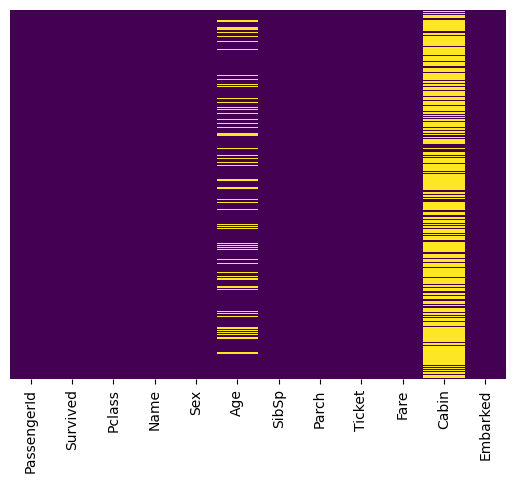

In [6]:
sns.heatmap(train.isnull(), cbar = False, cmap='viridis', yticklabels= False )

Roughly 20 percent of the Age data is missing. The proportion of Age missing is likely small enough for reasonable replacement with some form of imputation. Looking at the Cabin column, it looks like we are just missing too much of that data to do something useful with at a basic level. We'll probably drop this later, or change it to another feature like "Cabin Known: 1 or 0"

Let's continue on by visualizing some more of the data! Check out the video for full explanations over these plots, this code is just to serve as reference.

<Axes: xlabel='Survived', ylabel='count'>

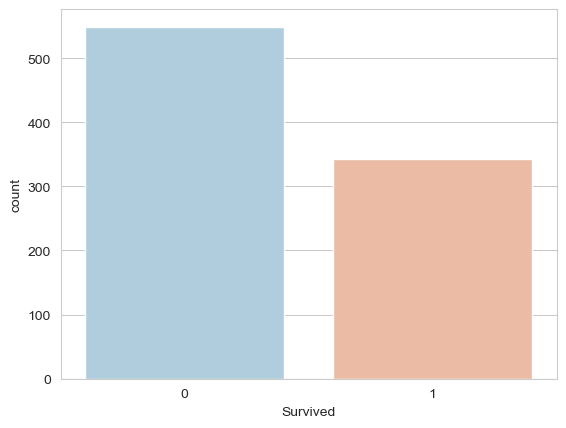

In [7]:
sns.set_style('whitegrid')
sns.countplot(x = 'Survived', data = train, palette='RdBu_r')

<Axes: xlabel='Survived', ylabel='count'>

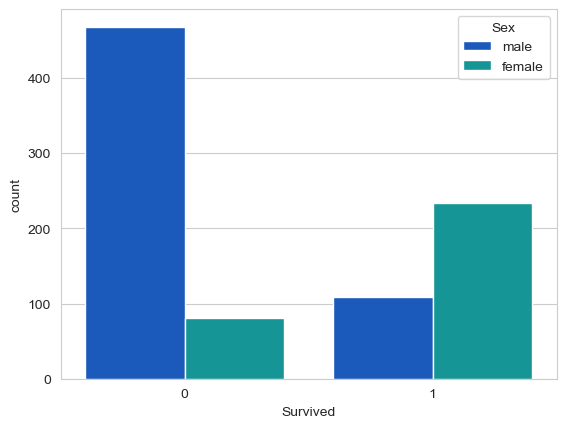

In [8]:
sns.set_style('whitegrid')
sns.countplot(x = 'Survived', hue='Sex', data = train, palette='winter')

<Axes: xlabel='Survived', ylabel='count'>

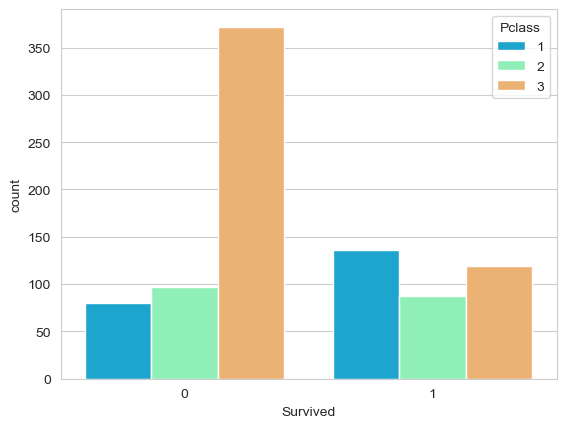

In [9]:
sns.set_style('whitegrid')
sns.countplot(x = 'Survived', hue='Pclass', data = train, palette='rainbow')

C:\Users\Chidera\AppData\Local\Temp\ipykernel_12152\2423461276.py:1: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(train['Age'].dropna(), bins = 30)


<Axes: xlabel='Age', ylabel='Density'>

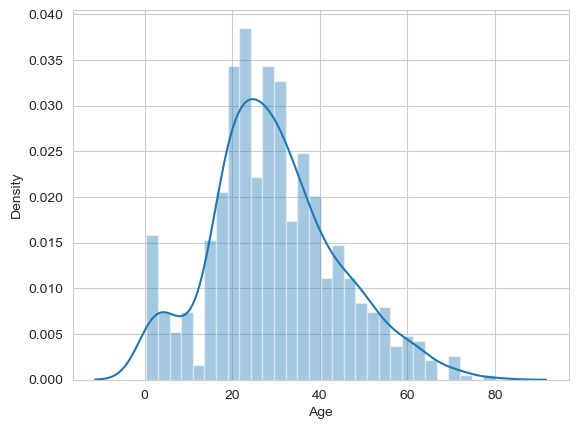

In [10]:
sns.distplot(train['Age'].dropna(), bins = 30)

<Axes: >

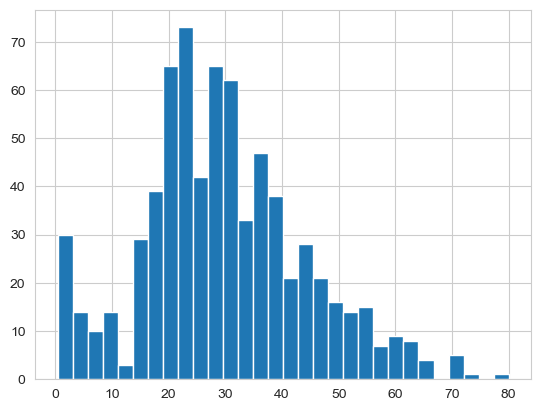

In [11]:
#what does the alpha argument do
train['Age'].hist(bins = 30, alpha = 1)

<Axes: xlabel='SibSp', ylabel='count'>

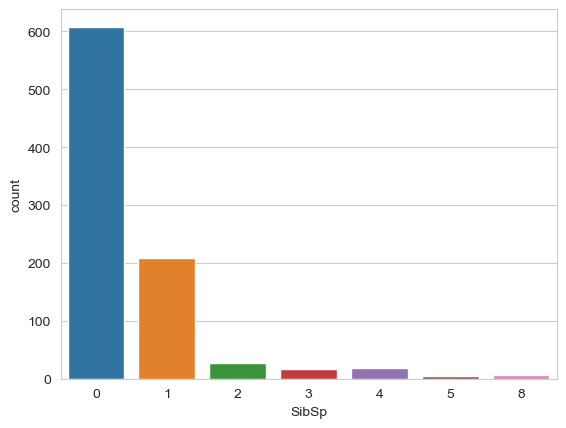

In [12]:
sns.countplot(x = 'SibSp', data = train)

<Axes: >

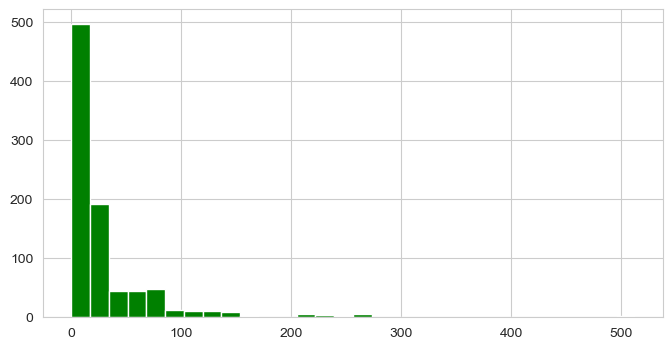

In [13]:
train['Fare'].hist(bins = 30, color='green', figsize=(8, 4))

___
## Data Cleaning
We want to fill in missing age data instead of just dropping the missing age data rows. One way to do this is by filling in the mean age of all the passengers (imputation).
However we can be smarter about this and check the average age by passenger class. For example:


<Axes: xlabel='Pclass', ylabel='Age'>

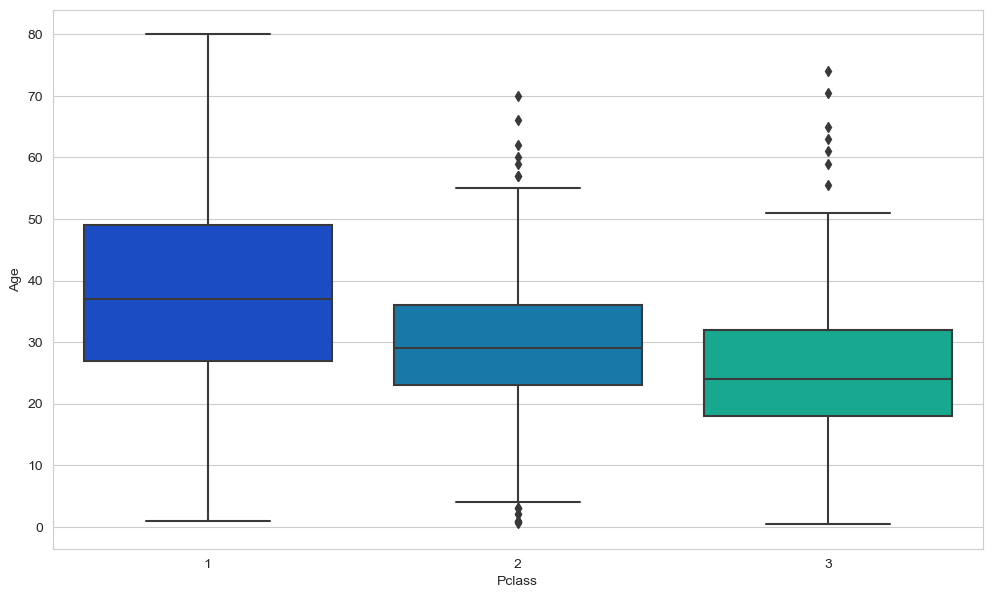

In [14]:
plt.figure(figsize=(12, 7))
sns.boxplot(x='Pclass', y='Age', data = train, palette='winter')

We can see the wealthier passengers in the higher classes tend to be older, which makes sense. We'll use these average age values to impute based on Pclass for Age.

In [15]:
def impute_age(cols):
    Age = cols[0]
    Pclass = cols[1]
    
    if pd.isnull(Age):
        
        if Pclass == 1:
            return 37
        elif Pclass == 2:
            return 29
        else:
            return 24
    else:
        return Age

Now apply that function!

In [16]:
train['Age'] = train[['Age', 'Pclass']]. apply (impute_age , axis=1)

Now let's check that heat map again!

<Axes: >

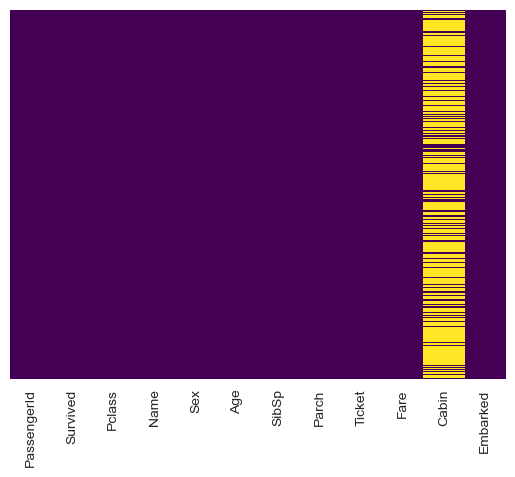

In [17]:
sns.heatmap(train.isnull(), cbar = False, cmap='viridis', yticklabels= False )

Great! Let's go ahead and drop the Cabin column and the row in Embarked that is NaN.

In [18]:
train.drop('Cabin', axis = 1, inplace = True )

In [19]:
train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,S


In [20]:
train.dropna(inplace = True )

## Converting Categorical Features 

We'll need to convert categorical features to dummy variables using pandas! Otherwise our machine learning algorithm won't be able to directly take in those features as inputs.

In [21]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 889 entries, 0 to 890
Data columns (total 11 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  889 non-null    int64  
 1   Survived     889 non-null    int64  
 2   Pclass       889 non-null    int64  
 3   Name         889 non-null    object 
 4   Sex          889 non-null    object 
 5   Age          889 non-null    float64
 6   SibSp        889 non-null    int64  
 7   Parch        889 non-null    int64  
 8   Ticket       889 non-null    object 
 9   Fare         889 non-null    float64
 10  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(4)
memory usage: 83.3+ KB


In [22]:
sex = pd.get_dummies(train['Sex'], drop_first = True)
embark = pd.get_dummies(train['Embarked'], drop_first = True)

In [23]:
#dropping all text data
train.drop(['Sex', 'Embarked', 'Name', 'Ticket'], axis = 1, inplace = True)

In [24]:
#add new sex and embark columns
train = pd.concat([train, sex, embark], axis = 1)

In [25]:
train.head()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare,male,Q,S
0,1,0,3,22.0,1,0,7.2500,1,0,1
1,2,1,1,38.0,1,0,71.2833,0,0,0
2,3,1,3,26.0,0,0,7.9250,0,0,1
3,4,1,1,35.0,1,0,53.1000,0,0,1
4,5,0,3,35.0,0,0,8.0500,1,0,1


Great! Our data is ready for our model!

# Building a Logistic Regression model

Let's start by splitting our data into a training set and test set (there is another test.csv file that you can play around with in case you want to use all this data for training).

## Train Test Split

In [26]:
from sklearn.model_selection import train_test_split

In [27]:
#train_test_split(shift + tab, copy example)
X_train, X_test, y_train, y_test = train_test_split(train.drop('Survived', axis = 1), train['Survived'], test_size=0.3, random_state=101)

## Training and Predicting

In [29]:
from sklearn.linear_model import LogisticRegression

In [30]:
logmodel = LogisticRegression(solver = 'liblinear')
logmodel.fit(X_train, y_train)
# solver = 'default' -- acc 80%

LogisticRegression(solver='liblinear')

In [32]:
predictions = logmodel.predict(X_test)

Let's move on to evaluate our model!

## Evaluation

We can check precision,recall,f1-score using classification report!

In [33]:
from sklearn.metrics import classification_report

In [34]:
print(classification_report(y_test, predictions))

              precision    recall  f1-score   support

           0       0.81      0.93      0.86       163
           1       0.85      0.65      0.74       104

    accuracy                           0.82       267
   macro avg       0.83      0.79      0.80       267
weighted avg       0.82      0.82      0.81       267



Not so bad! You might want to explore other feature engineering and the other titanic_text.csv file, some suggestions for feature engineering:

* Try grabbing the Title (Dr.,Mr.,Mrs,etc..) from the name as a feature
* Maybe the Cabin letter could be a feature
* Is there any info you can get from the ticket?

## Great Job!

In [35]:
from sklearn.metrics import confusion_matrix, accuracy_score

In [36]:
print(confusion_matrix(y_test, predictions))

[[151  12]
 [ 36  68]]


In [37]:
print(f'Accuracy Score: {accuracy_score(y_test, predictions)}' )

Accuracy Score: 0.8202247191011236


## Bonus

#### Create the confusion matrix with a heatmap

In [38]:
class_names = {0: 'Deceased', 1: 'Survived'}

In [39]:
matrix = confusion_matrix(y_test, predictions)

In [40]:
class_names = ['Deceased', 'Suvived']

In [41]:
#Create a data frame for the matrix
df = pd.DataFrame(matrix, index = class_names, columns = class_names)

In [42]:
df

,Deceased,Suvived
Deceased,151,12
Suvived,36,68


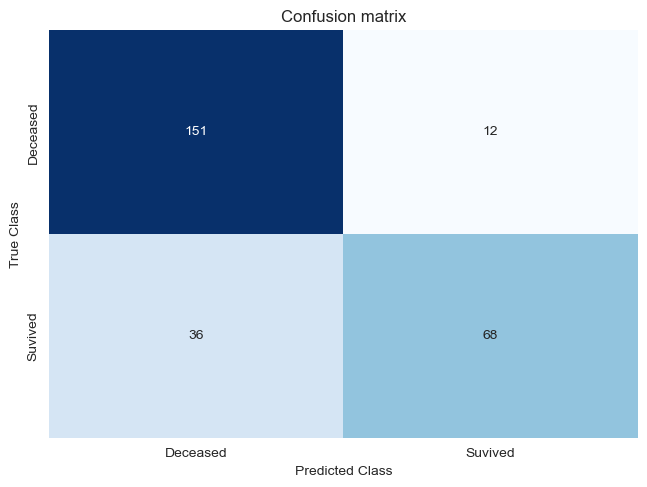

In [43]:
sns.heatmap(df, annot = True, cbar = None, cmap = 'Blues', fmt = 'g')
plt.title('Confusion matrix')
plt.tight_layout()
plt.ylabel('True Class')
plt.xlabel('Predicted Class')
plt.show()

## Using the model and working with the titanic_test data

ValueError: The feature names should match those that were passed during fit.
Feature names unseen at fit time:
- Cabin
- Embarked
- Name
- Sex
- Ticket
Feature names seen at fit time, yet now missing:
- Q
- S
- male
